## Credit Card Fraud Detection

In [136]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
import seaborn as sns
import collections
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from xgboost import XGBClassifier
from pylab import rcParams
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from tqdm import tqdm, tqdm_notebook
from itertools import cycle

In [39]:
# PyTorch Packages
import torch.nn as nn
from torch.autograd import Variable as V
import torch
from torch.utils.data import DataLoader

# SKLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score)
from sklearn.metrics import accuracy_score, precision_score

# Plotting packages
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, NumeralTickFormatter
from bokeh.palettes import Set3_12
from bokeh.transform import jitter

In [93]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
output_notebook()

Loading BokehJS ...

In [41]:
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

### Load and prepare data

In [42]:
data = pd.read_csv('C:/Users/Aleksandra/PythonProjects/Anomaly detection/data/creditcard.csv',sep=',')

print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [43]:
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [45]:
data.shape

(284807, 31)

In [46]:
#Get 10% sample
data1= data.sample(frac = 0.1,random_state=1)
data1.shape

(28481, 31)

In [47]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [11]:
data.isnull().values.any() #no null values

False

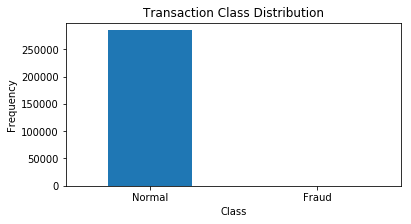

In [12]:
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0,figsize=(6, 3))
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [13]:
Fraud = data[data['Class']==1]
Normal = data[data['Class']==0]

In [14]:
Fraud.shape

(492, 31)

In [15]:
Normal.shape

(284315, 31)

In [57]:
print("Fraud fraction : {}".format((len(Fraud)/(len(Normal)+len(Fraud))*100)))

Fraud fraction : 0.017231435765427412


In [27]:
Fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [28]:
Normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

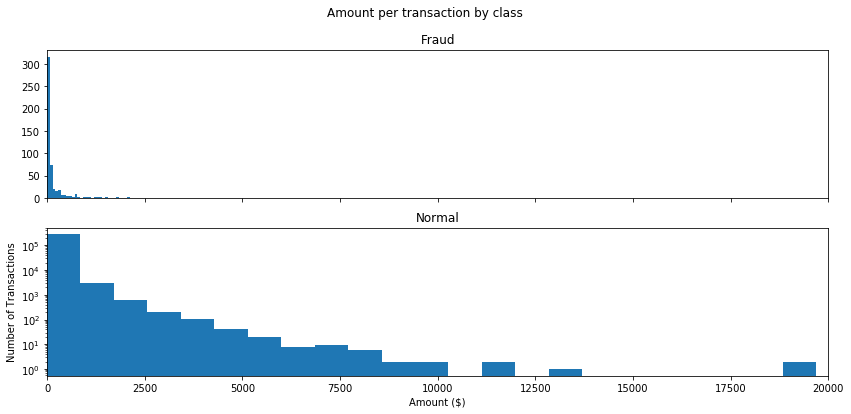

In [29]:

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(14, 6))
f.suptitle('Amount per transaction by class')
bins = 30
ax1.hist(Fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()


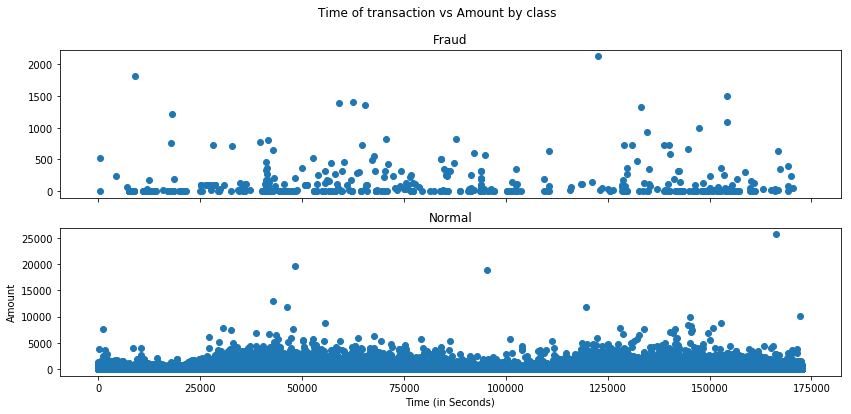

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(14, 6))
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(Normal.Time, Normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [33]:
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

In [34]:
trace = go.Scatter(
    x = Fraud.Time,
    y = Fraud.Amount,
    mode = 'markers'
)
data = [trace]
#trace is just the name we give a collection of data and the specifications of which we want that data plotted

In [35]:
plotly.offline.iplot({
    "data": data
})

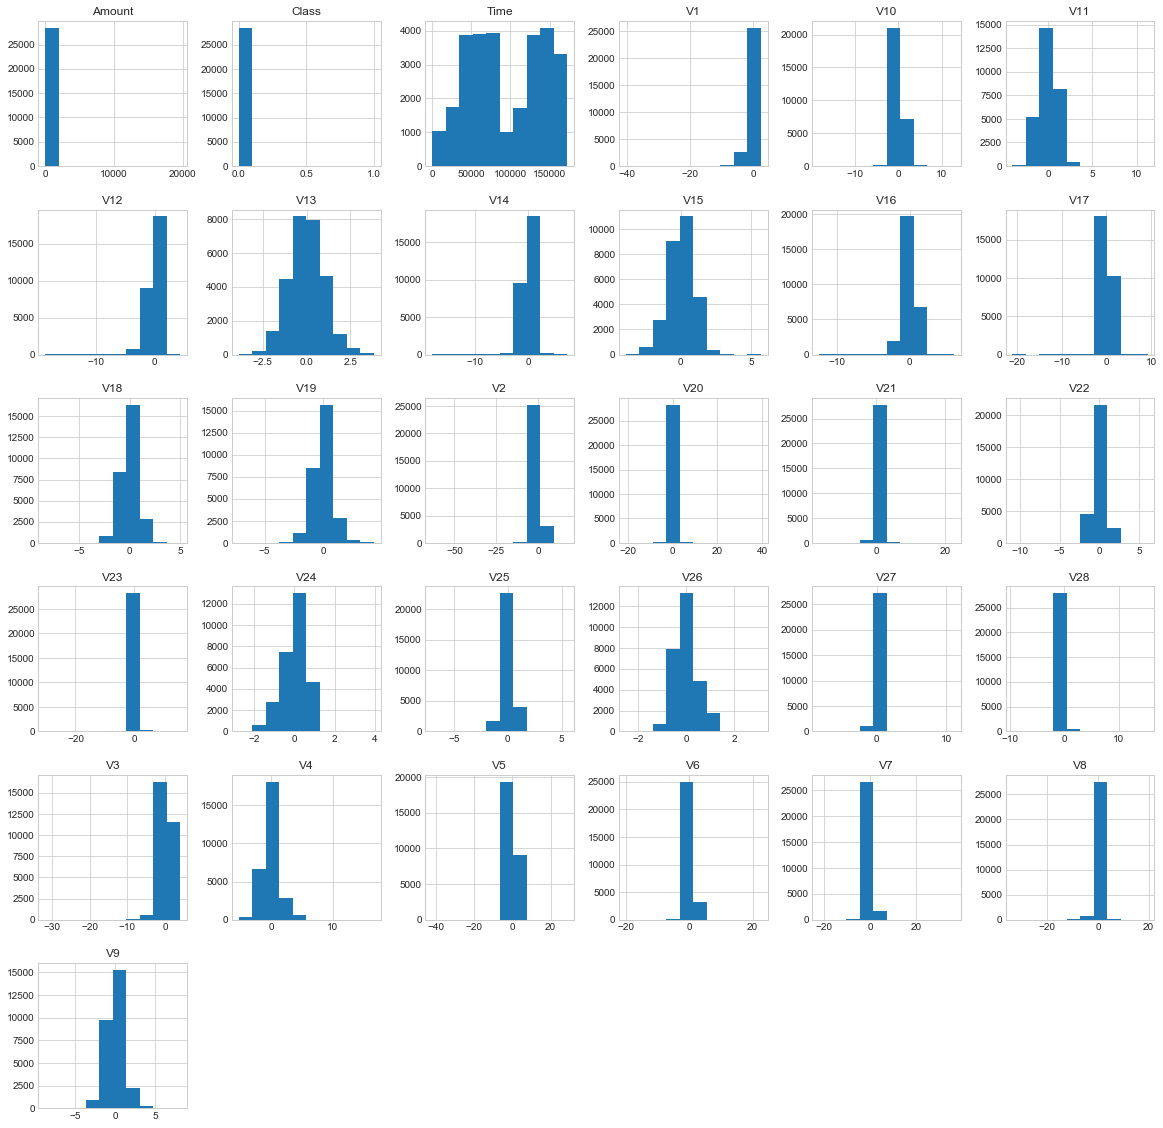

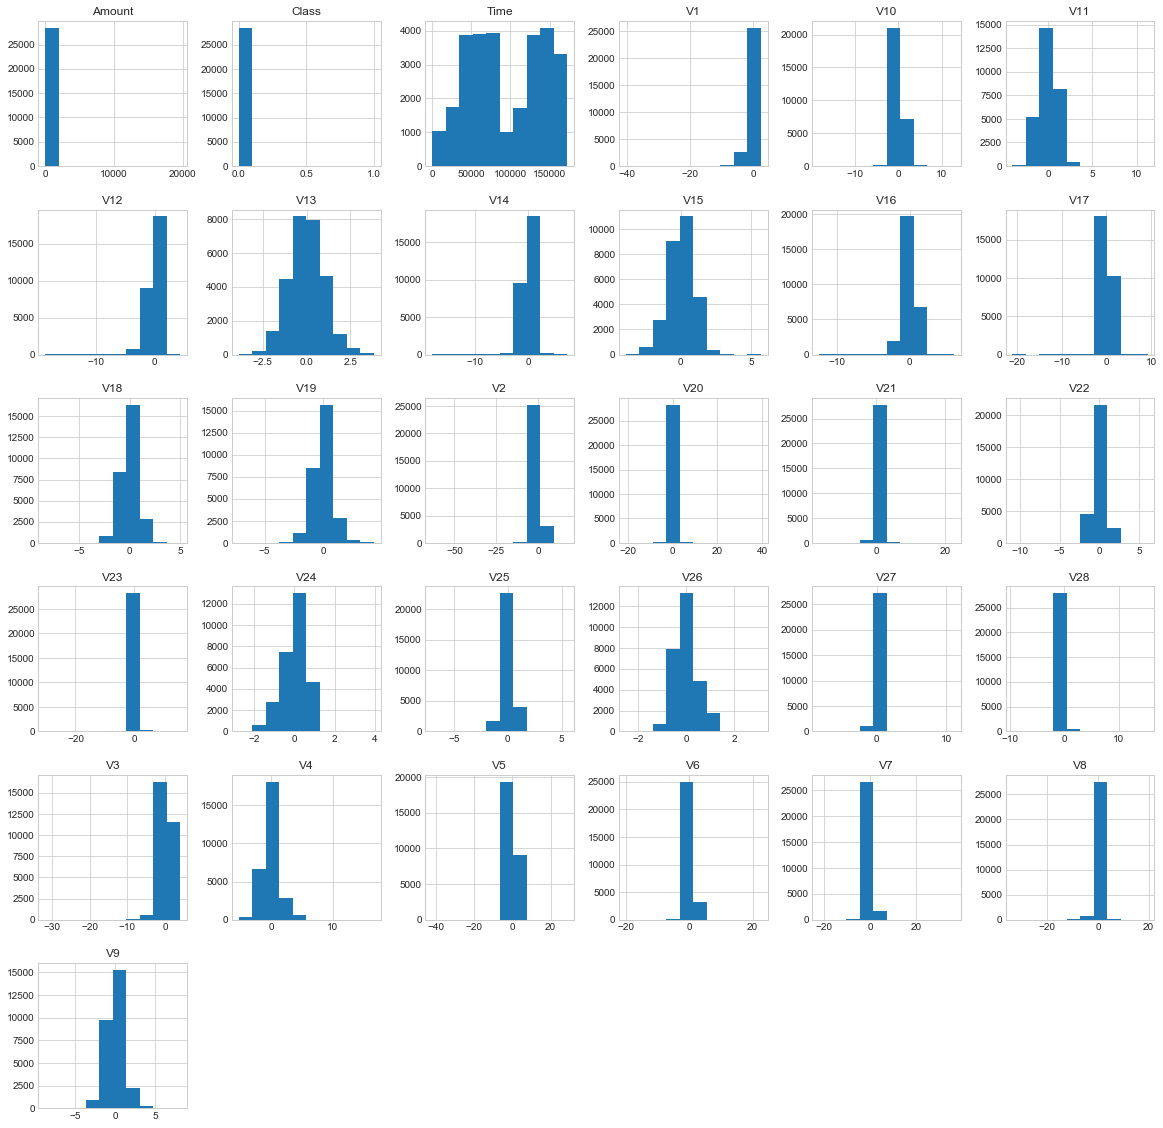

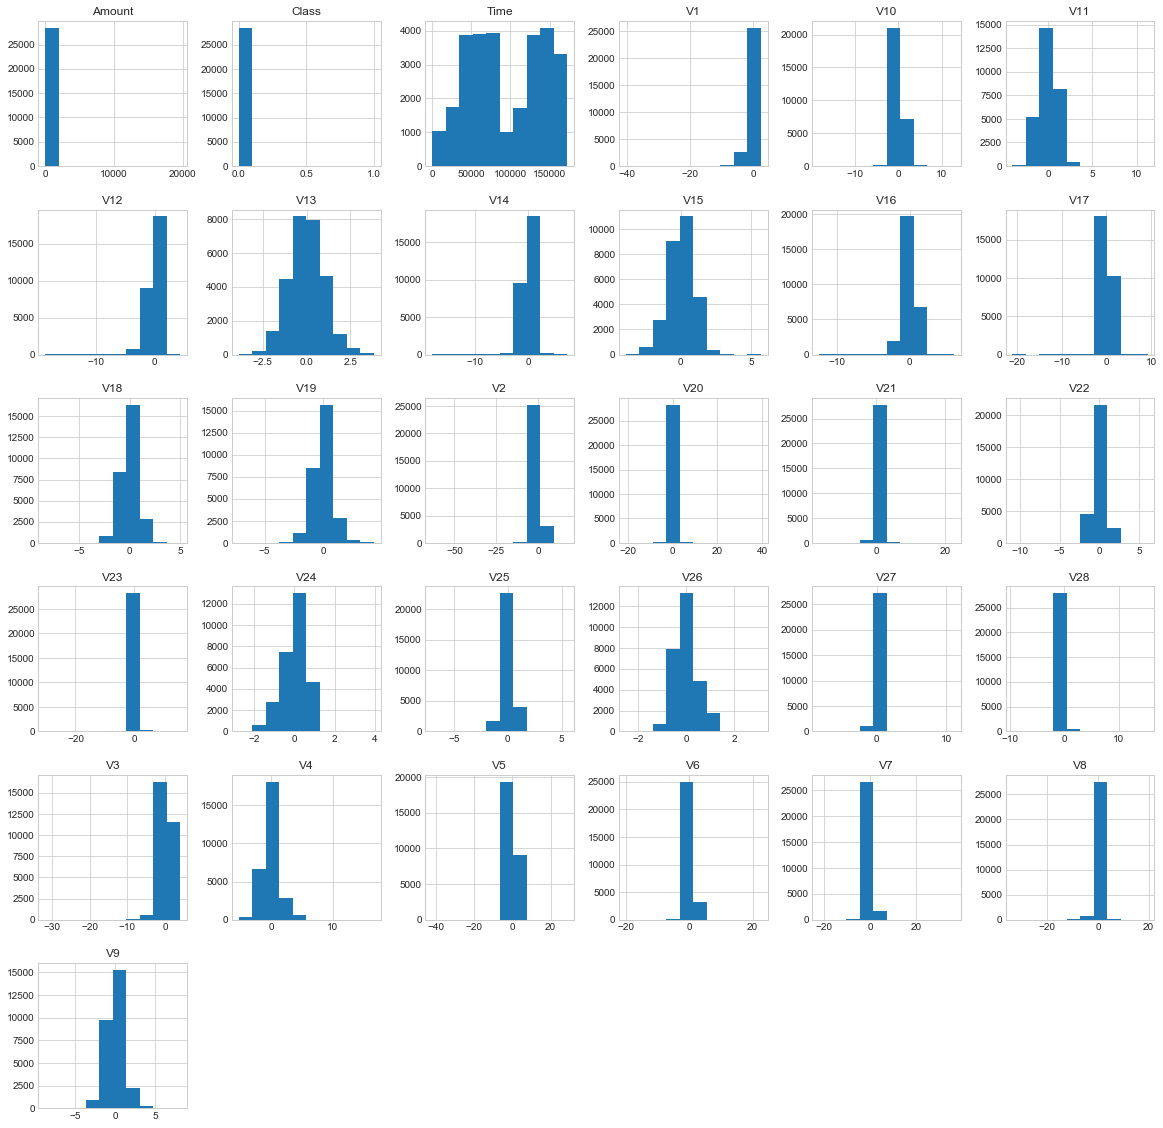

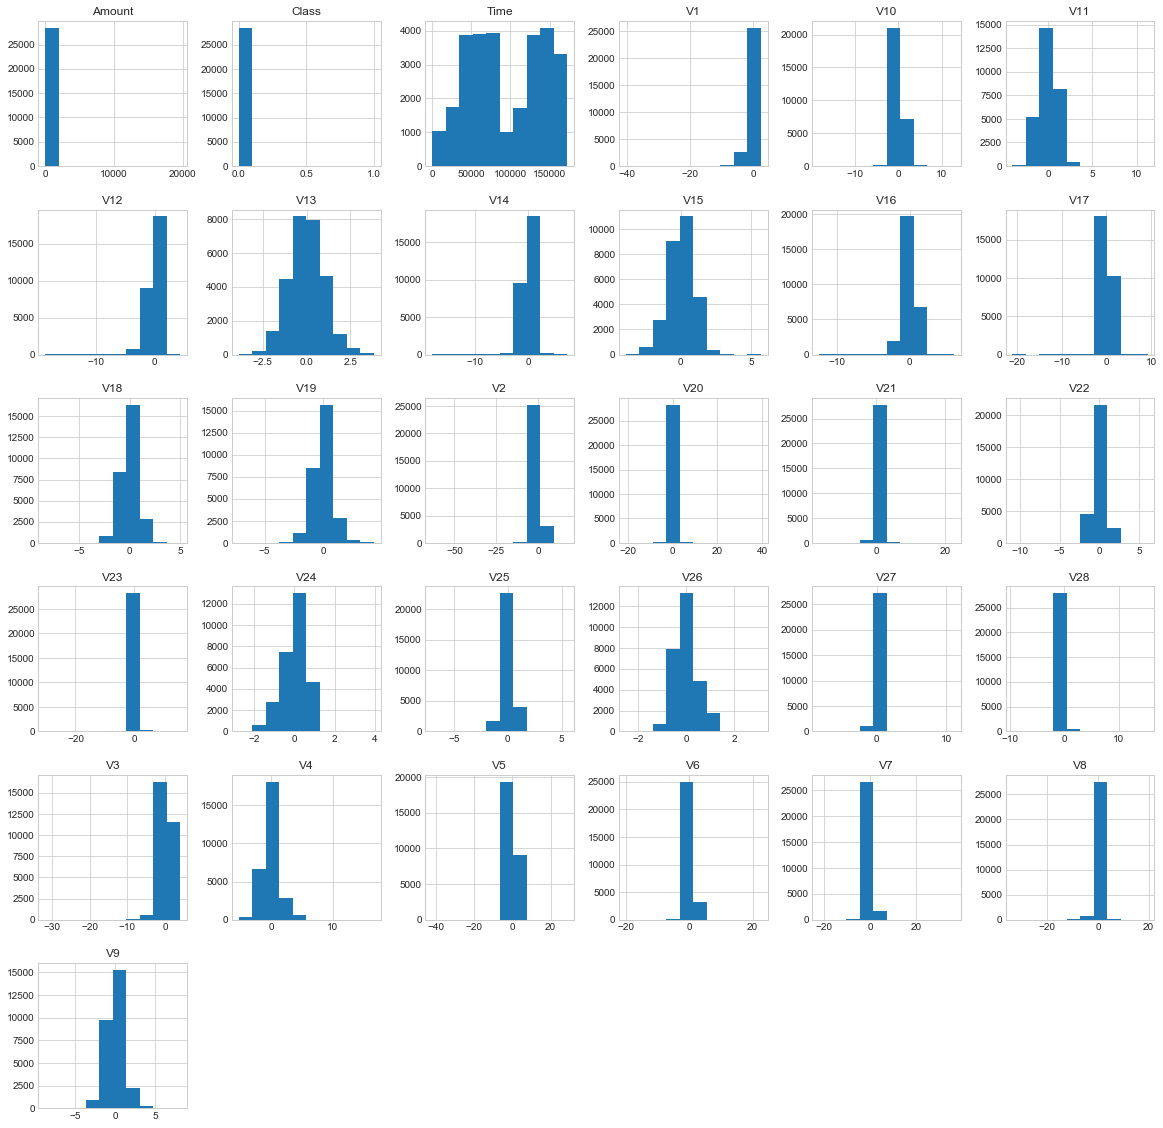

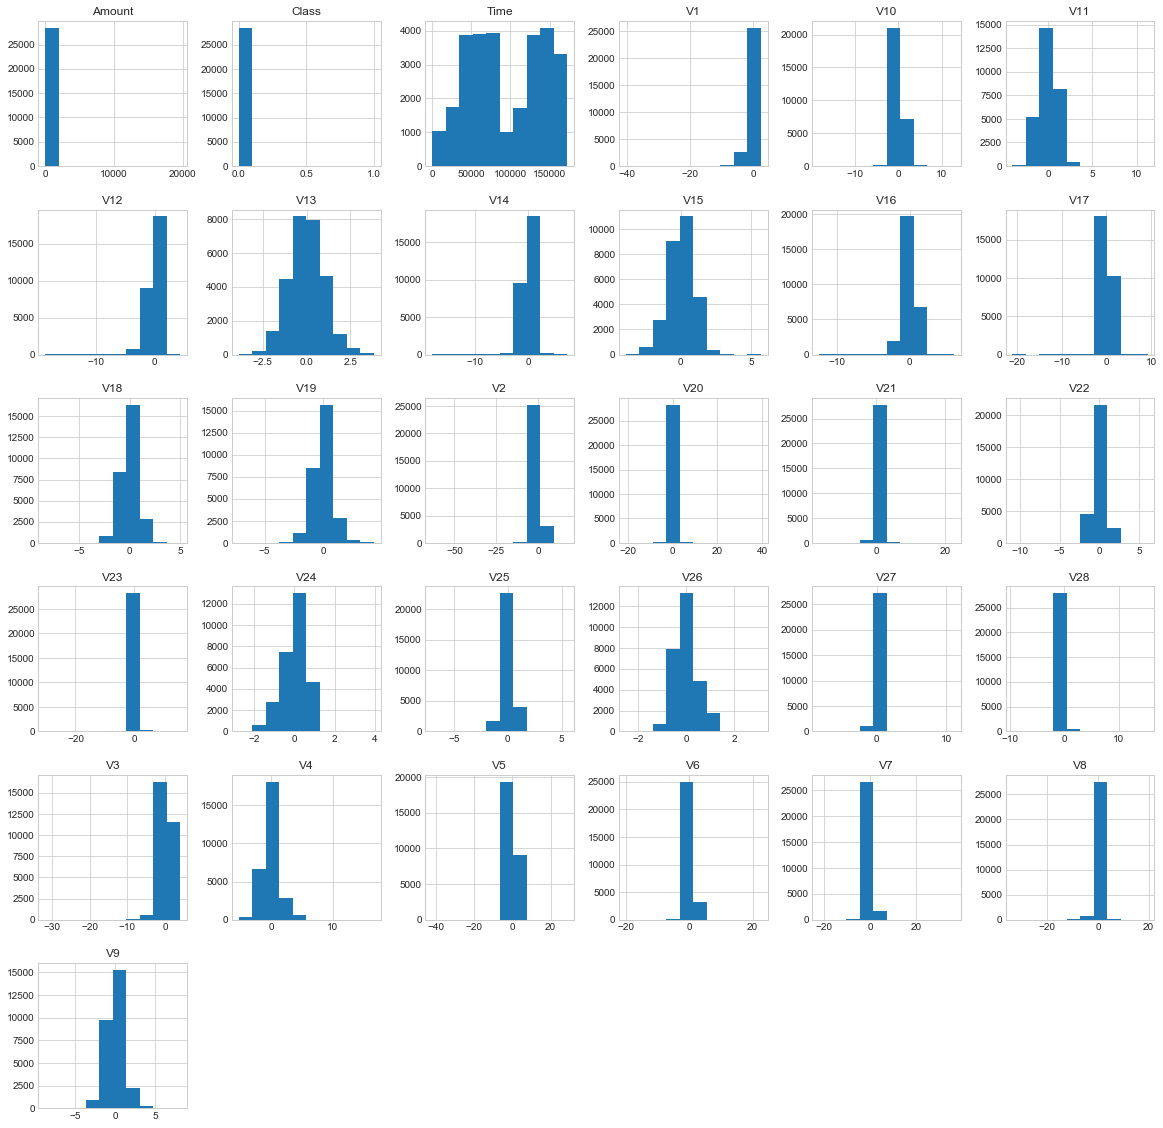

In [146]:
#Working on sample, undersampling to deal with class imbalance
data1.hist(figsize=(20,20))
plt.show()



In [49]:
Fraud = data1[data1['Class']==1]
Valid = data1[data1['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [55]:
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


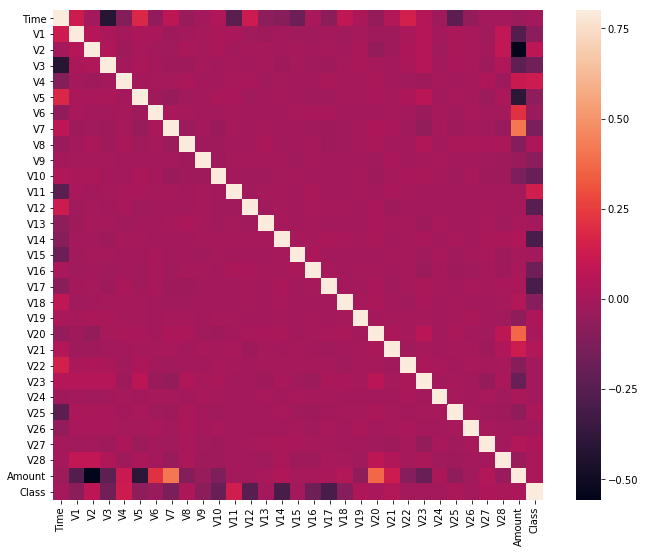

In [58]:
correlation_matrix = data1.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

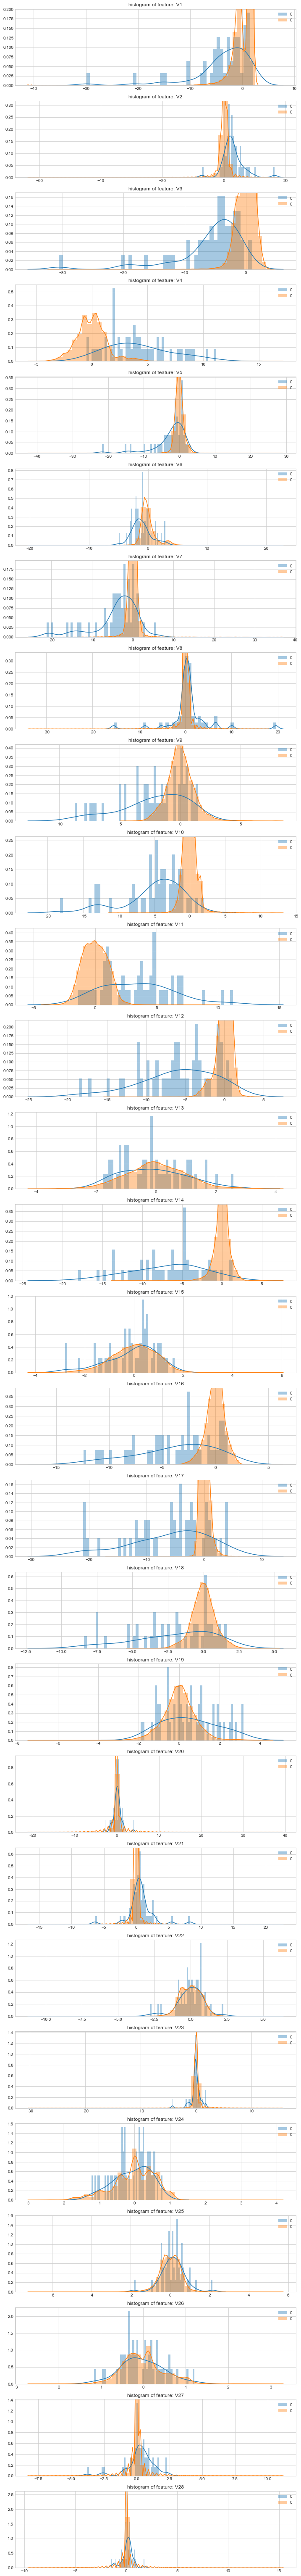

In [95]:
v_features = data1.iloc[:,1:29].columns
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(data1[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data1[cn][data1.Class == 1], bins=50)
    sns.distplot(data1[cn][data1.Class == 0], bins=50)
    ax.set_xlabel('')
    plt.legend(data1["Class"])
    ax.set_title('histogram of feature: ' + str(cn))
    
plt.show()

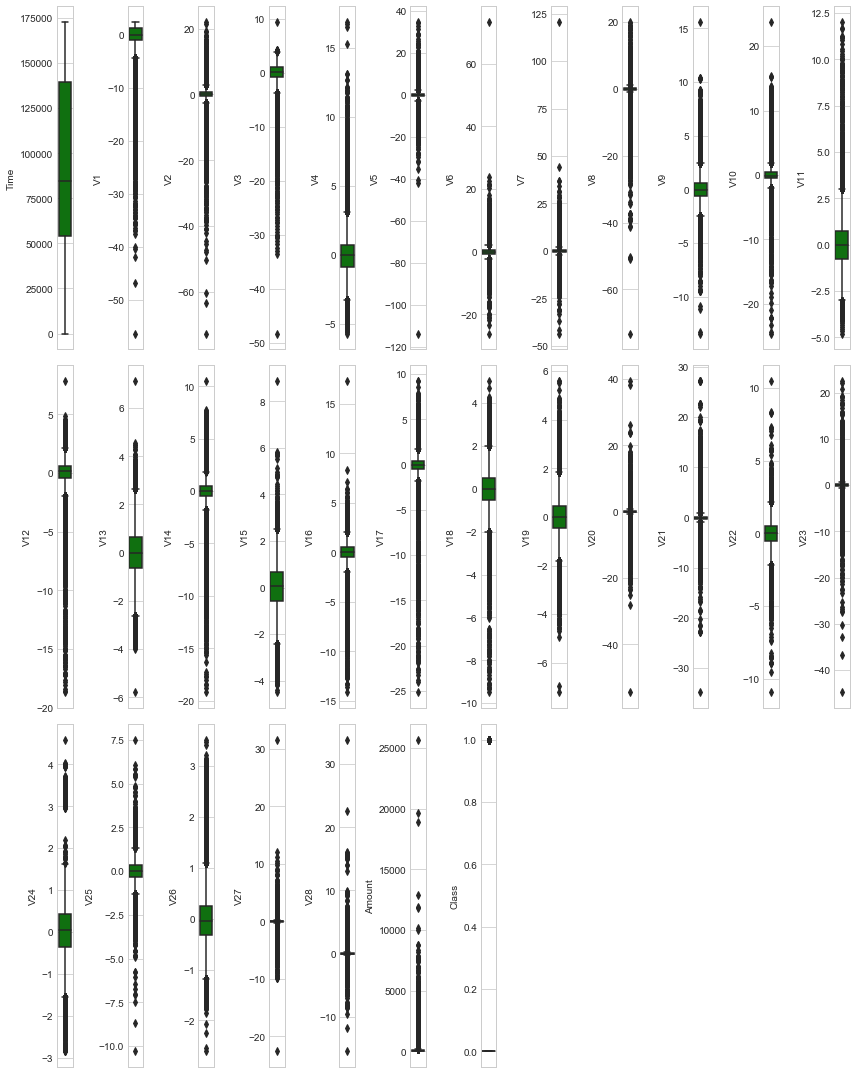

In [66]:
l = data.columns.values
number_of_columns=12
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data[l[i]],color='green',orient='v')
    plt.tight_layout()
plt.show()

In [63]:
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


### Isolation Forest - Local Outlier Factor - Support Vector Machine models

In [67]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=state)
   
}

In [94]:
n_outliers = len(Fraud)

for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

   micro avg       1.00      1.00      1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

   micro avg       1.00      1.00      1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Support Vector Machine: 8516
Accuracy Score :
0.7009936448860644
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.70   

### Autoencoders

In [69]:
df = pd.read_csv('C:/Users/Aleksandra/PythonProjects/Anomaly detection/data/creditcard.csv',sep=',')

In [70]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [71]:
#df["Time"] = pd.to_datetime(df["Time"])

In [72]:
df['TimeNorm'] = df['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24.)

In [73]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,TimeNorm
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0,1.0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0,1.0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0,1.0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0,1.0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0,1.0


In [74]:
def format_plot(p, x_label, y_label):
    p.grid.grid_line_color = None
    p.background_fill_color = "whitesmoke"
    p.axis.minor_tick_line_color = None
    p.title.align = 'center'
    p.title.text_font_size = "18px"
    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.xaxis.axis_label_text_font_size = "14px"
    p.yaxis.axis_label_text_font_size = "14px"
    p.yaxis.axis_line_color = None
    p.yaxis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "12px"
    return p

In [75]:
# Get only fraud transactions
fraud_df = df[df['Class'] == 1]
f_source = ColumnDataSource(data = dict(x = fraud_df['TimeNorm'].values,
                                    y = fraud_df['Amount'].values))
# get only normal transactions
non_fraud_df = df[df['Class'] == 0]
# Limit amount of data in plot
sample_non_fraud = df.sample(frac=0.01, replace=False)
norm_source = ColumnDataSource(data = dict(x = sample_non_fraud['TimeNorm'].values,
                                    y = sample_non_fraud['Amount'].values))
# create Bokeh figure
p = figure(plot_width = 800, 
           toolbar_location = None, 
           title = 'Transactions by Time and Amount')

# plot Normal Transactions
p.circle(x=jitter('x', width=0.9, range=p.x_range), 
         y='y', color = Set3_12[4], 
         fill_alpha = 0.1, 
         source = norm_source)

# plot fraud transactions
p.circle(x=jitter('x', width=0.9,range=p.x_range), 
         y='y', color = Set3_12[3], 
         fill_alpha = 0.7, 
         source = f_source)

#function to format plot
p = format_plot(p, "Time", "Amount")

p.yaxis[0].formatter = NumeralTickFormatter(format="$0,0")

show(p)

In [76]:
#no clear time window when fraud occurs more frequently.

In [77]:
scl = StandardScaler()
df['TimeNorm'] = scl.fit_transform(df['TimeNorm'].values.reshape(-1,1))
scl = StandardScaler()
df['NormAmt'] = scl.fit_transform(df['Amount'].values.reshape(-1,1))

In [78]:
df = df.drop(['Time', 'Amount'], axis = 1)

In [79]:
x_train, x_test = train_test_split(df, test_size = 0.2, random_state = 42)

In [80]:
x_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,TimeNorm,NormAmt
223361,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,...,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,0,0.300989,-0.313289
165061,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,...,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,0,-0.822459,-0.169717
238186,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,...,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,0,0.621974,-0.305292
150562,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,...,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,0,-1.785414,0.116306
138452,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,...,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,0,1.424436,-0.250239


In [81]:
#autoencoder will learn the features of a normal transaction, so we filter the training set to remove all transactions that were fraudulent from the training set 

In [82]:
x_train = x_train[x_train['Class'] == 0]
y_train = x_train['Class'].values
x_train = x_train.drop('Class', axis = 1)


y_test = x_test['Class'].values
x_test = x_test.drop('Class', axis = 1)
x_test = x_test.values
x_train = x_train.values

x_train.shape, x_test.shape

((227451, 30), (56962, 30))

In [83]:
#transform the numpy arrays as a PyTorch Float Tensor and loaded them into a DataLoader object 

xt = torch.FloatTensor(x_train)
xtr = torch.FloatTensor(x_test)
xdl = DataLoader(xt,batch_size = 1000)
tdl = DataLoader(xtr, batch_size = 1000)

In [84]:
#4 fully connected layers starting at an input size of 30 (30 variables) reducing down to 10 and then decoding back up to 30

In [85]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(30,20)
        self.lin2 = nn.Linear(20,10)
        self.lin7 = nn.Linear(10,20)
        self.lin8 = nn.Linear(20,30)
        
        self.drop2 = nn.Dropout(0.05)
        
        self.lin1.weight.data.uniform_(-2,2)
        self.lin2.weight.data.uniform_(-2,2)
        self.lin7.weight.data.uniform_(-2,2)
        self.lin8.weight.data.uniform_(-2,2)

    def forward(self, data):
        x = torch.tanh(self.lin1(data))
        x = self.drop2(torch.tanh(self.lin2(x)))
        x = torch.tanh(self.lin7(x))
        x = self.lin8(x)
        
        return (x)

In [86]:
# function utilizes the model's loss function to calculate the loss for the validation test set. In this instance of using an autoencoder for anomaly detection, the validation score doesn't mean much since it will have both fraud and non-fraud scores. 

In [87]:
def score(x):
    y_pred = model(V(x))
    x1 = V(x)
    return loss(y_pred,x1).item()

In [88]:
# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

In [89]:
def train(epochs, model, model_loss):
    try:c = model_loss.epoch[-1]
    except: c = 0
    for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):
        losses=[]
        dl = iter(xdl)
        for t in range(len(dl)):
            # Forward pass: compute predicted y and loss by passing x to the model.
            xt = next(dl)
            y_pred = model(V(xt))
            
            l = loss(y_pred,V(xt))
            losses.append(l)
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            l.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()
    
        val_dl = iter(tdl)
        val_scores = [score(next(val_dl)) for i in range(len(val_dl))]
        
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(l.item())
        model_loss.val_loss.append(np.mean(val_scores))
        print(f'Epoch: {epoch}   Loss: {l.item():.4f}    Val_Loss: {np.mean(val_scores):.4f}')

In [90]:
model = Net1()
loss=nn.MSELoss()
learning_rate = 1e-2
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
train(model = model, epochs = 30,model_loss= model_loss)

Epoch: 0   Loss: 0.9970    Val_Loss: 1.1238
Epoch: 1   Loss: 0.8469    Val_Loss: 0.9657
Epoch: 2   Loss: 0.7983    Val_Loss: 0.9136
Epoch: 3   Loss: 0.7505    Val_Loss: 0.8485
Epoch: 4   Loss: 0.6871    Val_Loss: 0.7806
Epoch: 5   Loss: 0.6183    Val_Loss: 0.7282
Epoch: 6   Loss: 0.6023    Val_Loss: 0.6951
Epoch: 7   Loss: 0.5730    Val_Loss: 0.6693
Epoch: 8   Loss: 0.5458    Val_Loss: 0.6439
Epoch: 9   Loss: 0.5298    Val_Loss: 0.6232
Epoch: 10   Loss: 0.4980    Val_Loss: 0.6079
Epoch: 11   Loss: 0.4916    Val_Loss: 0.5936
Epoch: 12   Loss: 0.4695    Val_Loss: 0.5811
Epoch: 13   Loss: 0.4593    Val_Loss: 0.5705
Epoch: 14   Loss: 0.4488    Val_Loss: 0.5585
Epoch: 15   Loss: 0.4493    Val_Loss: 0.5461
Epoch: 16   Loss: 0.4205    Val_Loss: 0.5306
Epoch: 17   Loss: 0.4189    Val_Loss: 0.5164


KeyboardInterrupt: 

### Tensorflow

In [96]:
import tensorflow as tf

In [97]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

227451
227451
56962
56962


In [98]:
# Split the testing data into validation and testing sets
inputX_valid, inputX_test, inputY_valid, inputY_test = train_test_split(x_train, y_train, test_size=0.5)
print (inputX_valid.shape, inputY_valid.shape)
print (inputX_test.shape, inputY_test.shape)

(113725, 30) (113725,)
(113726, 30) (113726,)


In [118]:
# Number of input nodes.
input_nodes = 30 #37?

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 1.5 

# Number of nodes in each hidden layer
hidden_nodes1 = 18
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

# Percent of nodes to keep during dropout.
pkeep = tf.placeholder(tf.float32)

In [100]:
#ValueError: Cannot feed value of shape (2048, 30) for Tensor 'Placeholder_1:0', which has shape '(?, 37)'

In [106]:
# Parameters
training_epochs = 5 # should be 2000, it will timeout when uploading
training_dropout = 0.7
display_step = 1 # 10 
n_samples = y_train.shape[0]
batch_size = 1024
learning_rate = 0.005

In [119]:
x = tf.placeholder(tf.float32, [None, input_nodes])

# layer 1
W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev = 0.15))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev = 0.15))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

# layer 3
W3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev = 0.15)) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)
y3 = tf.nn.dropout(y3, pkeep)

# layer 4
W4 = tf.Variable(tf.truncated_normal([hidden_nodes3, 2], stddev = 0.15)) 
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

# output
y = y4
#y_ = tf.placeholder(tf.float32, [None, 2])
y_ = tf.placeholder(tf.float32, [None, 2])

In [120]:
n_samples

227451

In [124]:
# Cost function: Cross Entropy
cost = -tf.reduce_sum(y_ * tf.log(y))

# We will optimize our model via AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Correct prediction if the most likely value (Fraud or Normal) from softmax equals the target value.
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [125]:
accuracy_summary = [] # Record accuracy values for plot
cost_summary = [] # Record cost values for plot
valid_accuracy_summary = [] 
valid_cost_summary = [] 
stop_early = 0 # To keep track of the number of epochs before early stopping

In [128]:


# Save the best weights so that they can be used to make the final predictions
#checkpoint = "best_model.ckpt"
#saver = tf.train.Saver(max_to_keep=1)

# Initialize variables and tensorflow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs): 
        for batch in range(int(n_samples/batch_size)):
            batch_x = x_train[batch*batch_size : (1+batch)*batch_size]
            batch_y = y_train[batch*batch_size : (1+batch)*batch_size]

            sess.run([optimizer], feed_dict={x: batch_x, y_: batch_y, pkeep: training_dropout})

        # Display logs after every 10 epochs
        if (epoch) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: x_train, y_: y_train, pkeep: training_dropout})
            valid_accuracy, valid_newCost = sess.run([accuracy, cost], feed_dict={x: inputX_valid, y_: inputY_valid, pkeep: 1})

            print ("Epoch:", epoch,
                   "Acc =", "{:.5f}".format(train_accuracy), 
                   "Cost =", "{:.5f}".format(newCost),
                   "Valid_Acc =", "{:.5f}".format(valid_accuracy), 
                   "Valid_Cost = ", "{:.5f}".format(valid_newCost))
            
            
            # Record the results of the model
            accuracy_summary.append(train_accuracy)
            cost_summary.append(newCost)
            valid_accuracy_summary.append(valid_accuracy)
            valid_cost_summary.append(valid_newCost)
            
            # If the model does not improve after 15 logs, stop the training.
            if valid_accuracy < max(valid_accuracy_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 15:
                    break
            else:
                stop_early = 0
            
    print()
    print("Optimization Finished!")
    print()   

ValueError: Cannot feed value of shape (1024,) for Tensor 'Placeholder_13:0', which has shape '(?, 2)'

In [ ]:
# Plot the accuracy and cost summaries 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary) # blue
ax1.plot(valid_accuracy_summary) # green
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.plot(valid_cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x10)')
plt.show()

### t-SNE 

In [ ]:
# New_df is from the random undersample data (fewer instances)
X = df.drop('Class', axis=1)
y = df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

### XGBoost 

In [133]:
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=7)


In [140]:
# use area under the precision-recall curve to show classification accuracy
scoring = 'roc_auc'
results = cross_val_score(model, x_train, y_train, cv=kfold, scoring = scoring)
print( "AUC: %.3f (%.3f)" % (results.mean(), results.std()) )

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [139]:
# plot roc-curve
# code adapted from http://scikit-learn.org
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(kfold.split(x_train, y_train), colors):
    probas_ = model.fit(x_train, y_train).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= kfold.get_n_splits(X, Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


KeyError: '[ 2847  2848  2849 ... 28478 28479 28480] not in index'